In [4]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.tensorboard import SummaryWriter

import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from models_v2 import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

from tqdm import tqdm
import imageio

from utils_hf import *

savedir = "models/hill_gauss_gauss"
os.makedirs(savedir, exist_ok=True)



For this problem we consider the potential 
$$
F(\rho) = \int -\frac{\alpha}{2}||x||^2\rho(x)dx
$$

In [5]:
# Problem set up

dim = 2
batch_size = 256
n_iters = 20_000
architecture = 'MLP'
ot_sampler = OTPlanSampler(method="exact")

In [17]:
mean_1 = torch.tensor([-3., 0.])
cov_1 = torch.eye(dim)

mean_2 = torch.tensor([3., 0.])
cov_2 = torch.tensor([[2., -1.], [-1., 2.]])

# Set up for reference distribution

ref_dist = MultivariateNormal(mean_1, cov_1)
targ_dist = MultivariateNormal(mean_2, cov_2)

In [18]:
sigma = 0.1


# model_ent_match = ResNet(dim= dim,hidden=2,time_varying= True)
if architecture == 'MLP':
    model_harmonic = ResNet(dim= dim,w=64,time_varying= True)
else: 
    model_harmonic = MLP(dim= dim,w=64,time_varying= True)
optimizer = torch.optim.Adam(model_harmonic.parameters(), lr=1e-3)

In [19]:
alpha = torch.tensor([3.0])

# Dynamics for std

const_1 = sigma*(torch.exp((2*alpha)**(1/2))-torch.exp(-(2*alpha)**(1/2)))**(-1)
const_2 = (1-torch.exp(-(2*alpha)**(1/2)))
const_3 = (torch.exp((2*alpha)**(1/2))-1)

sig_t_f = lambda t : const_1*(const_2*torch.exp((2*alpha)**(1/2)*t)+const_3*torch.exp(-(2*alpha)**(1/2)*t))
sig_t_prime_f = lambda t : const_1*(const_2*(2*alpha)**(1/2)*torch.exp((2*alpha)**(1/2)*t)-const_3*(2*alpha)**(1/2)*torch.exp(-(2*alpha)**(1/2)*t))

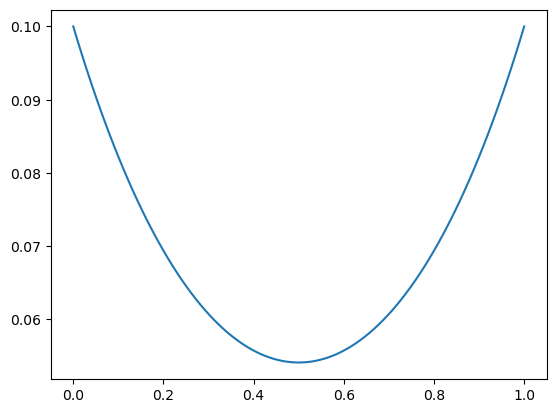

In [20]:
t = torch.linspace(0,1,100)

plt.plot(t,sig_t_f(t))

In [21]:
const_1m = (torch.exp((alpha)**(1/2))-torch.exp(-(alpha)**(1/2)))**(-1)


Loss: 9.395:   0%|          | 0/20000 [00:00<?, ?it/s]

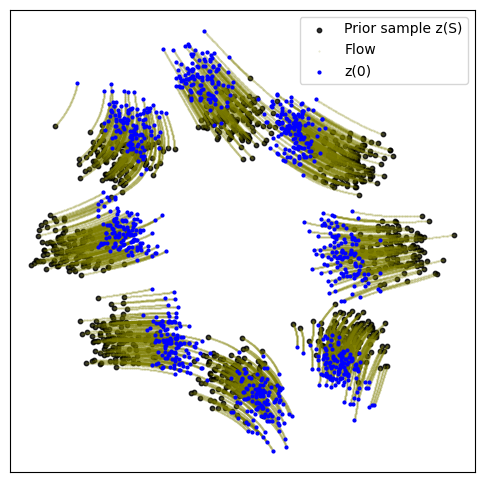

Loss: 0.182:  25%|██▌       | 5000/20000 [01:26<04:06, 60.87it/s]

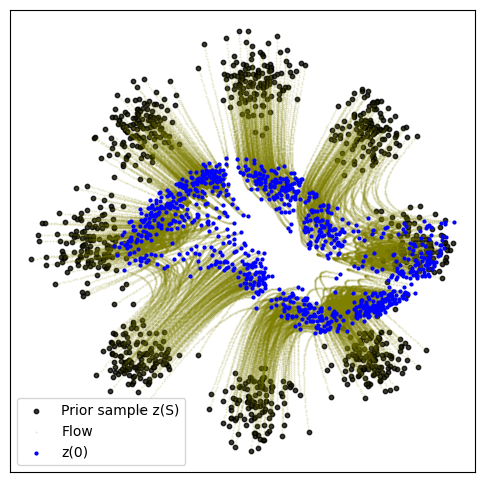

Loss: 0.102:  50%|█████     | 10000/20000 [02:53<02:47, 59.64it/s]

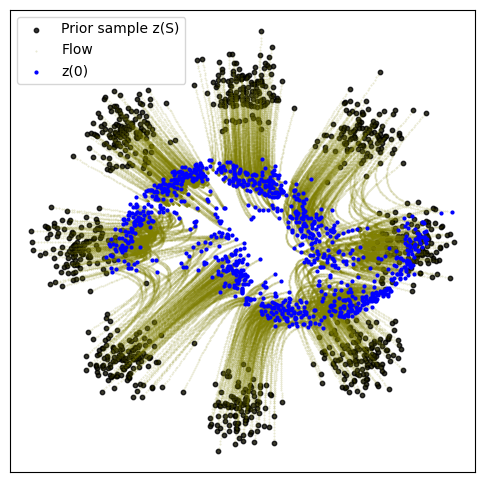

Loss: 0.103:  75%|███████▌  | 15000/20000 [04:18<01:20, 62.11it/s]

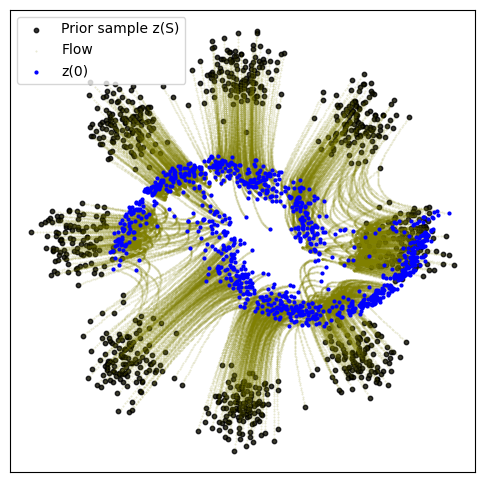

100%|██████████| 20000/20000 [05:45<00:00, 57.93it/s]0, 59.50it/s]


Loss: 0.073: 100%|██████████| 20000/20000 [06:04<00:00, 59.50it/s]

In [22]:

# FM = HarmonicOscillatorConditionalFlowMatcher(U = U,sigma= sigma,ot_method= "exact")
pbar = tqdm(total=n_iters, desc="Training")
writer = SummaryWriter()
for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand((batch_size,1))

    # x0 = ref_dist.sample((batch_size,))
    # x1 = targ_dist.sample((batch_size,))
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    x0, x1 = ot_sampler.sample_plan(x0, x1)

    x0 = x0#.unsqueeze(-1)
    x1 = x1#.unsqueeze(-1)

    

    mu_t = const_1m*(torch.exp((alpha)**(1/2)*t)*(-x0*torch.exp(-(alpha)**(1/2)) +x1) +torch.exp(-(alpha)**(1/2)*t)*(x0*torch.exp((alpha)**(1/2)) -x1))
    mu_t_prime = (alpha)**(1/2)*const_1m*((-x0*torch.exp(-(alpha)**(1/2)) +x1)*torch.exp((alpha)**(1/2)*t) -(x0*torch.exp((alpha)**(1/2)) -x1)*torch.exp(-(alpha)**(1/2)*t))

    sig_t = sig_t_f(t)
    sig_t_prime = sig_t_prime_f(t)
    

    
    epsilon = torch.randn_like(x0)#.squeeze(-1)
    
    xt = mu_t + sig_t*epsilon
    ut = sig_t_prime*(xt-mu_t)/(sig_t+1e-8) + mu_t_prime

    # t,xt,ut = FM.sample_location_and_conditional_flow(x0, x1)

    # print(t.shape,xt.shape,ut.shape)

    vt = model_harmonic(torch.cat([xt,t],dim = -1))
    # loss = torch.mean(torch.norm(vt - ut)**2)
    loss = torch.nn.MSELoss()(vt,ut)
    writer.add_scalar('Loss', loss.item(), k)

    # Update the progress bar
    pbar.set_description("Loss: %.3f" % loss.item())
    pbar.update()
    

    loss.backward()
    optimizer.step()

    if (k ) % 5000 == 0:
        node = NeuralODE(
            torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            # print(loss.item())
            traj = node.trajectory(
                # ref_dist.sample((1000,)),
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())



In [45]:
torch.save(model_harmonic.state_dict(), os.path.join(savedir, f"hill_model_{architecture}_gauss_gauss_20000.pt"))

In [42]:
model_harmonic.eval()

ResNet(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): SELU()
    (2-3): 2 x ResBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
      (selu): SELU()
    )
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

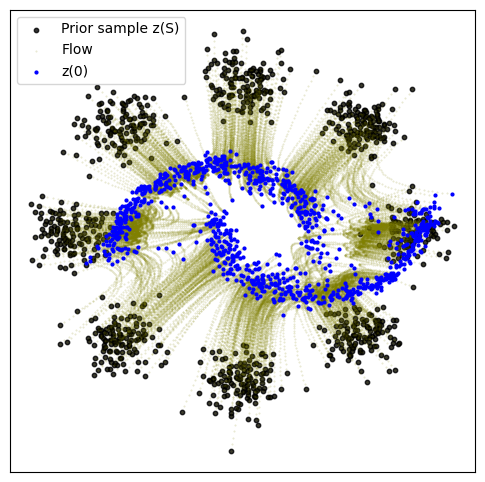

In [24]:
node = NeuralODE(torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
with torch.no_grad():
    traj = node.trajectory(
                # ref_dist.sample((1000,)),
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 50),
            )
    plot_trajectories(traj.cpu().numpy())
#     plt.savefig(os.path.join(savedir,f"traj_MLP_15_000.png"))

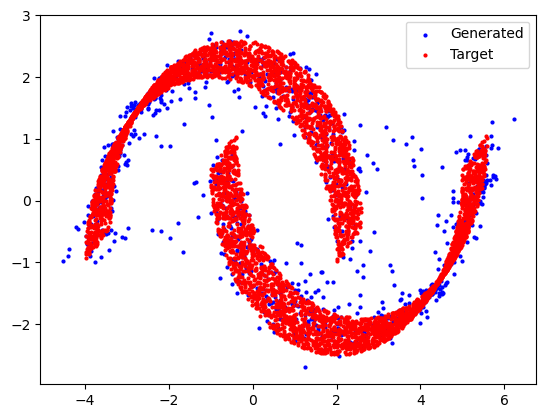

In [26]:
n = 2000
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
# samples = targ_dist.sample((5000,))
samples = sample_moons(5000)
plt.scatter(samples[:, 0], samples[:, 1], s=4, alpha=1, c="red")
plt.legend(["Generated", "Target"])
plt.show()

In [28]:
num_samples = 5000
# xx0 = ref_dist.sample((num_samples,))
xx0 = sample_8gaussians(num_samples)
gif_quiver(model_harmonic,savedir,xx0,num_samples,N = 50)